In [1]:
import os
import pandas as pd

In [2]:
cp_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_cplex_cp.txt'
ortools_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_ortools.txt'
gurobi_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_gurobi.txt'
cplp_path_fjssp = r'C:\Users\huda\Downloads\fjssp\fjssp\results_cplex_lp.txt'

In [3]:
cp_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_cplex_cp.txt'
ortools_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_ortools.txt'
cplp_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_cplex_lp_rewritten.txt'
gurobi_path_fjssp_w = r'C:\Users\huda\Downloads\results\results_gurobi.txt'

In [4]:
def read_file(file : str) -> pd.DataFrame:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    del file_content
    df = df.drop(columns=['result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram'])
    df = df[~df['name'].str.startswith('Error')]
    df = df[df['fitness_value'] != float('inf')]
    return df

In [5]:
cp_fjssp = read_file(cp_path_fjssp)
cp_fjssp_w = read_file(cp_path_fjssp_w)

In [6]:
cplp_fjssp = read_file(cplp_path_fjssp)
cplp_fjssp_w = read_file(cplp_path_fjssp_w)

In [7]:
gurobi_fjssp = read_file(gurobi_path_fjssp)
gurobi_fjssp_w = read_file(gurobi_path_fjssp_w)

In [8]:
ortools_fjssp = read_file(ortools_path_fjssp)
ortools_fjssp_w = read_file(ortools_path_fjssp_w)

In [9]:
ga_path_fjssp = r'C:\Users\huda\Downloads\ga_comparison\ga'
ga_path_fjssp_w = r'C:\Users\huda\Downloads\ga_comparison\fjssp_w'

In [10]:
import json
def rewrite(path_to_results):
    files = os.listdir(path_to_results)
    json_data = {}
    for file in files:
        with open(path_to_results + "\\" + file, 'r') as f:
            content = f.read()
            content = '{"' + content[1:7] + '"' + content[8:-1] + ']' + '}'
            json_data[file[:-9]] = content
    return json_data
ga_files = os.listdir(ga_path_fjssp)
ga_fjssp_data = rewrite(ga_path_fjssp)

In [11]:
ga_fjssp_w_data = dict()
files = os.listdir(ga_path_fjssp_w)
for file in files:
    with open(ga_path_fjssp_w + '/' + file, 'r') as f:
        json_data = json.loads(f.read())
        ga_fjssp_w_data[file[:-9]] = json_data

In [12]:
ga_average_fjssp = dict()
ga_average_fjssp_w = dict()
ga_best_fjssp = dict()
ga_best_fjssp_w = dict()
for instance in ga_fjssp_data:
    ga_best_fjssp[instance] = float('inf')
    ga_average_fjssp[instance] = 0
    ga_instance_data = json.loads(ga_fjssp_data[instance])
    for run in ga_instance_data['result']:
        fitness = run['Result']['Fitness']['Makespan']
        if fitness < ga_best_fjssp[instance]:
            ga_best_fjssp[instance] = fitness
        ga_average_fjssp[instance] += fitness
    ga_average_fjssp[instance] /= len(ga_instance_data['result'])
for instance in ga_fjssp_w_data:
    ga_best_fjssp_w[instance] = float('inf')
    ga_average_fjssp_w[instance] = 0
    for run in ga_fjssp_w_data[instance]['results']:
        fitness = run['Result']['Fitness']['Makespan']
        if fitness < ga_best_fjssp_w[instance]:
            ga_best_fjssp_w[instance] = fitness
        ga_average_fjssp_w[instance] += fitness
    ga_average_fjssp_w[instance] /= len( ga_fjssp_w_data[instance]['results'])
    

In [13]:
ortools_fjssp[ortools_fjssp['optimization_status'] == 1].count()

name                   20
optimization_status    20
fitness_value          20
lower_bound            20
runtime                20
resource_history       20
best_result_history     0
dtype: int64

In [14]:
ortools_fjssp_w[ortools_fjssp_w['optimization_status'] == 1].count()

name                   39
optimization_status    39
fitness_value          39
lower_bound            39
runtime                39
resource_history       39
best_result_history    39
dtype: int64

In [15]:
def setup_dict():
    compare = dict()
    compare['worker'] = dict()
    compare['no_worker'] = dict()
    return compare

In [16]:
solver = dict()
solver['cplex_cp'] = dict()
solver['ortools'] = dict()
solver['ga_best'] = dict()
solver['ga_average'] = dict()
solver['gurobi'] = dict()
#solver['cplex_lp'] = dict()

In [17]:
compare = setup_dict()
for instance in ga_average_fjssp:
    compare['no_worker'][instance] = {
        'fitness': ga_average_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
for instance in ga_average_fjssp_w:
    compare['worker'][instance] = {
        'fitness': ga_average_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
solver['ga_average'] = compare

In [18]:
compare = setup_dict()
for instance in ga_best_fjssp:
    compare['no_worker'][instance] = {
        'fitness': ga_best_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
for instance in ga_best_fjssp_w:
    compare['worker'][instance] = {
        'fitness': ga_best_fjssp_w[instance],
        #'runtime': row['runtime'] # TODO: maybe?
    }
solver['ga_best'] = compare

In [19]:
def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[0].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[0].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[0].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('r'):
        return 'HurinkRdata'+values[-1]
    if values[0].startswith('Hurink') and values[1].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[0].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[0].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[0].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

In [20]:
def extract_solver_data(fjssp, fjssp_w):
    compare = setup_dict()
    for index, row in fjssp.iterrows():
        compare['no_worker'][row['name']] = {
            'fitness': row['fitness_value'],
            'lower_bound': row['lower_bound'],
            'status': row['optimization_status'],
            'runtime': row['runtime']
        }
    for index, row in fjssp_w.iterrows():
        name = remap(row['name'][2:-12])
        if name in compare['no_worker']:
            compare['worker'][name] = {
                'fitness': row['fitness_value'],
                'lower_bound': row['lower_bound'],
                'status': row['optimization_status'],
                'runtime': row['runtime']
            }
    return compare

In [21]:
solver['cplex_cp'] = extract_solver_data(cp_fjssp, cp_fjssp_w)
#solver['cplex_lp'] = extract_solver_data(cplp_fjssp, cplp_fjssp_w)
solver['gurobi'] = extract_solver_data(gurobi_fjssp, gurobi_fjssp_w)
solver['ortools'] = extract_solver_data(ortools_fjssp, ortools_fjssp_w)

In [22]:
import statistics
import math

def calculate_flexibility(machines_for_all_operations, n_machines): 
    counts = []

    for m in machines_for_all_operations:
        counts.append(len(m))
    
    return statistics.mean(counts) / n_machines

def calculate_duration_variety(durations):
    counts = []

    for d in durations:
        counts.append(len(d))

    return len(set(counts)) / len(counts)

def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs


In [23]:
def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev


In [24]:
from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser, BenchmarkParser
import os
includeWorkers = False
if includeWorkers:
    path = r'C:\Users\huda\Downloads\benchmarks_with_workers\benchmarks_with_workers'
    parser = WorkerBenchmarkParser()
else:
    path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks\all'
    parser = BenchmarkParser()
instances = os.listdir(path)
instance_data = dict()
consider_duration_features = True
for instance in instances:
    encoding = parser.parse_benchmark(path + "\\" + instance)
    feature_vector = []
    min_d, max_d, d_span, d_stdev = calculate_duration_features(encoding.durations())
    #TODO: worker data, or just do it with base FJSSP since all benchmarks are transformed in the same way
    extracted_data = {
        "name": instance,
        "n_jobs": encoding.n_jobs(), 
        "n_machines": encoding.n_machines(),
        "n_operations": encoding.n_operations(),
        "durations": encoding.durations(),
        "job_sequence": encoding.job_sequence(),
        "machines_for_all_operations": encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(),
        "flexibility": calculate_flexibility(encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(), encoding.n_machines()),
        "duration_variety": calculate_duration_variety(encoding.durations()),
        "average_operations": calculate_average_operations(encoding.job_sequence()),
        "min_duration": min_d,
        "max_duration": max_d,
        "duration_span": d_span,
        "duration_std": d_stdev
    }
    instance_data[instance[:-4]] = extracted_data


In [25]:
def print_instance(data):
    print(f"# Operations: {data['n_operations']} | # Machines: {data['n_machines']} | Flexibility: {data['flexibility']} | Duration Variety: {data['duration_variety']}")

In [26]:
def get_diff(solver, filter : bool = False, verbose : bool = False):
    diff = []
    o = []
    m = []
    f = []
    dv = []
    for instance in solver['worker']:
        if filter and min(solver["no_worker"][instance]["runtime"], 1200) == min(solver["worker"][instance]["runtime"], 1200):
            continue
        if verbose:
            print(instance)
            print_instance(instance_data[instance])
            print(f'FJSSP Status: {solver["no_worker"][instance]["status"]} | FJSSP-W Status: {solver["worker"][instance]["status"]}')
            print(f'FJSSP Runtime: {solver["no_worker"][instance]["runtime"]} | FJSSP-W Status: {solver["worker"][instance]["runtime"]}')
        diff.append(abs(solver["worker"][instance]["runtime"]-solver["no_worker"][instance]["runtime"]))
        o.append(instance_data[instance]['n_operations'])
        m.append(instance_data[instance]['n_machines'])
        f.append(instance_data[instance]['flexibility'])
        dv.append(instance_data[instance]['duration_variety'])
    return diff, o, m, f, dv

In [27]:
import matplotlib.pyplot as plt
def plot_runtime_difference(diff, o, m, f, dv, filter : bool = False):
    fig = plt.figure(layout='tight', figsize=(15, 8))
    axs = fig.subplots(2, 2)
    fig.suptitle(f'{"(Filtered)" if filter else ""} Benchmark Selection - FJSSP Benchmark Attributes')
    axs[0][0].scatter(diff, o)
    axs[0][0].set_title('Operations')
    axs[0][0].set_xlabel('runtime worker - runtime no worker')
    axs[0][0].set_ylabel('# operations')
    axs[0][1].scatter(diff, m)
    axs[0][1].set_title('Machines')
    axs[0][1].set_xlabel('runtime worker - runtime no worker')
    axs[0][1].set_ylabel('# machines')
    axs[1][0].scatter(diff, f)
    axs[1][0].set_title('Flexibility')
    axs[1][0].set_xlabel('runtime worker - runtime no worker')
    axs[1][0].set_ylabel('flexibility')
    axs[1][1].scatter(diff, dv)
    axs[1][1].set_title('Duration Variety')
    axs[1][1].set_xlabel('runtime worker - runtime no worker')
    axs[1][1].set_ylabel('duration variety')
    plt.show()


In [28]:
diff, o, m, f, dv = get_diff(solver['cplex_cp'], filter=True)

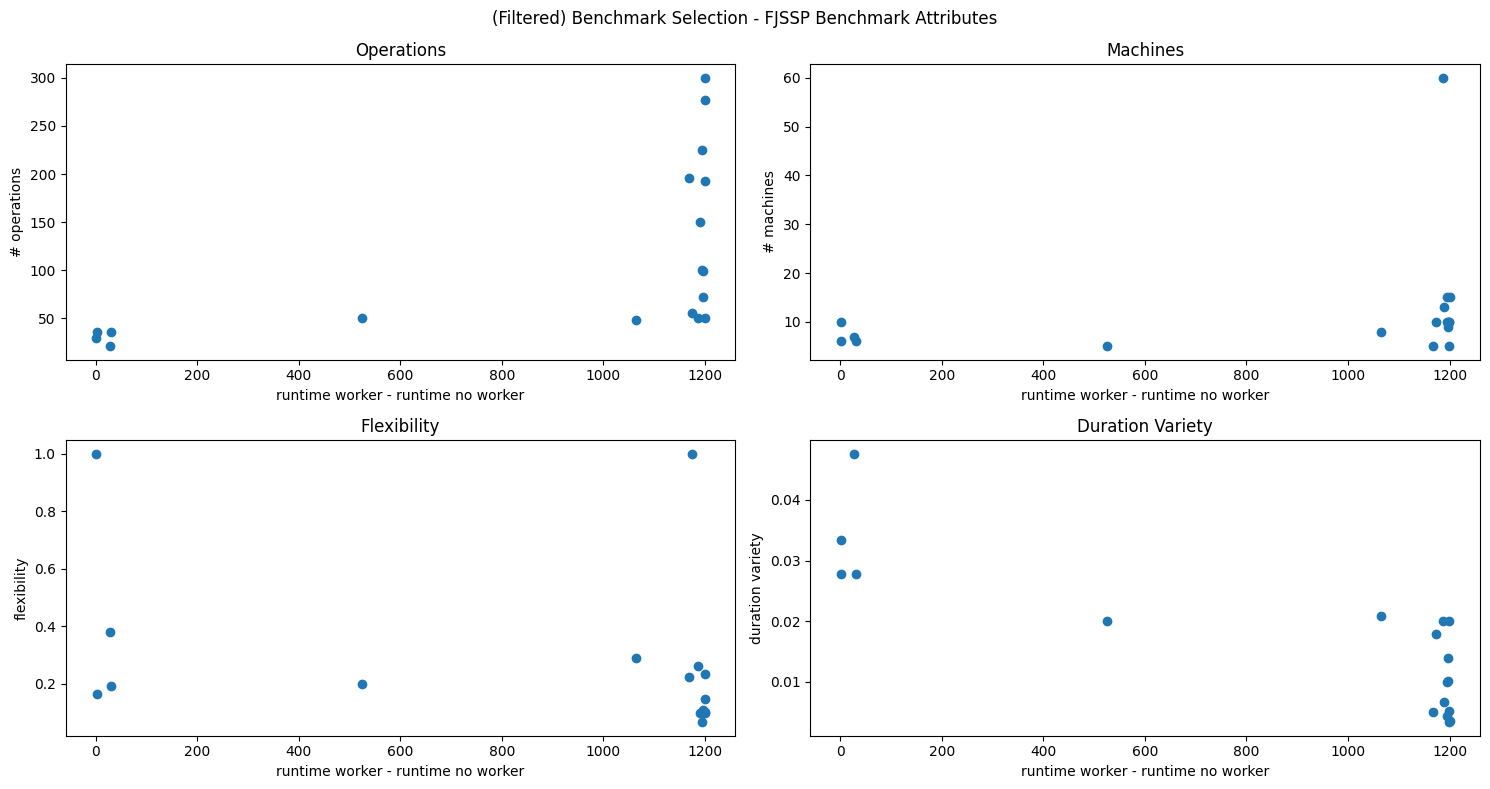

In [29]:
plot_runtime_difference(diff, o, m, f, dv, True)

In [30]:
diff, o, m, f, dv = get_diff(solver['ortools'], filter=True)

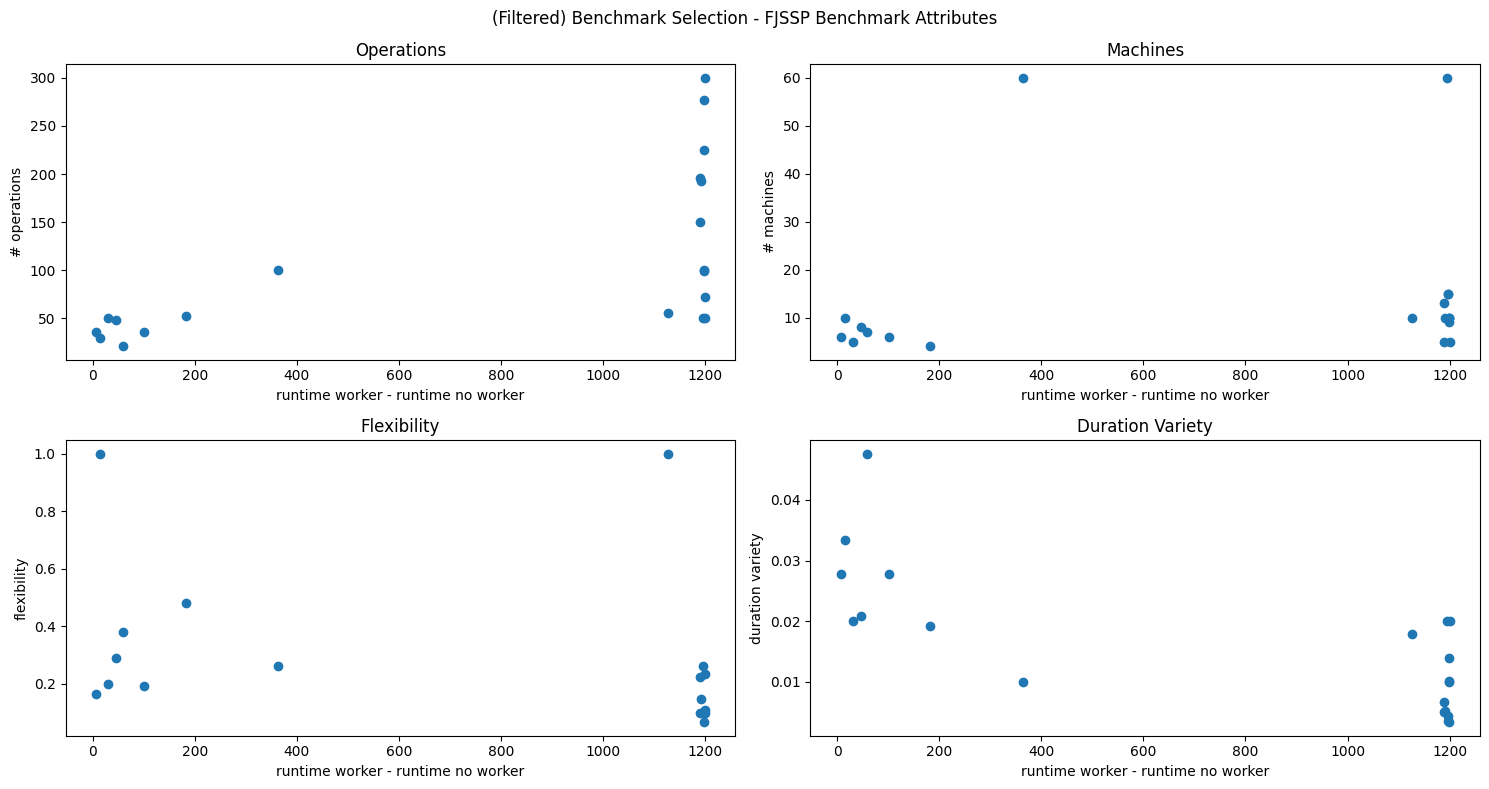

In [31]:
plot_runtime_difference(diff, o, m, f, dv, True)

In [32]:
def get_comparison(data, instance, column, max = False):
    best_fjssp = float('inf')
    best_fjssp_w = float('inf')
    for key in data.keys():
        if instance in data[key]['no_worker']:
            fitness_fjssp = data[key]['no_worker'][instance]['fitness']#optimizer['no_worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp < best_fjssp:
                best_fjssp = fitness_fjssp
        if instance in data[key]['worker']:
            fitness_fjssp_w = data[key]['worker'][instance]['fitness']#optimizer.loc[optimizer['worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp_w < best_fjssp_w:
                best_fjssp_w = fitness_fjssp_w
    return best_fjssp, best_fjssp_w

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_cdf_comparison_vector(data : dict, column, max, instances):
    results = []
    for _ in data:
        results.append([[],[]])
    for instance in instances:
        best_fjssp, best_fjssp_w = get_comparison(data, instance, column, max)
        i = 0
        for key in data.keys():
            if instance in data[key]['no_worker']:
                results[i][0].append(calculate_value(data[key]['no_worker'][instance]['fitness'], best_fjssp))
            if instance in data[key]['worker']:
                results[i][1].append(calculate_value(data[key]['worker'][instance]['fitness'], best_fjssp_w))
            i += 1
    for result in results:
        result[0].sort()
        result[1].sort()
    return results

In [193]:
plt.rcParams['axes.grid'] = True
def ecdf_inf(data, column = 'fitness_value', max : bool = False, n_instances : int = 30, labels : list[str] = [], instances : list[str] = [], colors : list[str] = []):
    vectors = get_cdf_comparison_vector(data, column, max, instances)
    plot_vectors = []

    for vector in vectors:
        plot_vectors.append([[[0.0],[0.0]], [[0.0],[0.0]]])
        i = 1
        while i < len(vector[0]):
            if vector[0][i] == float('inf'):
                break
            if vector[0][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0][0].append(vector[0][i-1])
            plot_vectors[-1][0][1].append((i-1)/n_instances)
            i += 1
        i = 1
        while i < len(vector[1]):
            if vector[1][i] == float('inf'):
                break
            if vector[1][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][1][0].append(vector[1][i-1])
            plot_vectors[-1][1][1].append((i-1)/n_instances)
            i += 1
    fig = plt.figure(layout='tight', figsize=(10, 5))
    axs = fig.subplots(1, 2)
    for i in range(len(vectors)):
        axs[0].plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i]], c=colors[i], linestyle='solid')
        axs[0].legend()
        axs[0].set_title('FJSSP')
        axs[0].set_xlim(-0.01, 0.7)
        axs[0].set_xlabel('$\delta_{rel}$')
        axs[0].set_ylabel('Portion of instances within Gap')
    for i in range(len(vectors)):
        axs[1].plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]], c=colors[i])
        axs[1].legend()
        axs[1].set_title('FJSSP-W')
        axs[1].set_xlabel('$\delta_{rel}$')
        axs[1].set_xlim(-0.01, 0.7)
    #for i in range(len(vectors)):
    #    plt.plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i] + ' FJSSP'], c=colors[i], linestyle='dashed', alpha=0.7)
    #    plt.legend()
    #    plt.plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]+ ' FJSSP-W'], c=colors[i], alpha=0.7)
    #    plt.legend()
    #plt.xlim(-0.1, 1.0)
    plt.legend()
    #plt.title('FJSSP - FJSSP-W')
    plt.show()


In [194]:
filtered_instances = list(solver['cplex_cp']['worker'].keys())

In [195]:
solver['ga_best']['worker']

{'Behnke42': {'fitness': 80.0},
 'Behnke46': {'fitness': 110.0},
 'Behnke60': {'fitness': 491.0},
 'BrandimarteMk12': {'fitness': 479.0},
 'BrandimarteMk14': {'fitness': 640.0},
 'BrandimarteMk7': {'fitness': 143.0},
 'ChambersBarnes10': {'fitness': 949.0},
 'DPpaulli1': {'fitness': 2728.0},
 'DPpaulli15': {'fitness': 2328.0},
 'DPpaulli18': {'fitness': 2305.0},
 'DPpaulli9': {'fitness': 2270.0},
 'Fattahi14': {'fitness': 538.0},
 'Fattahi20': {'fitness': 1208.0},
 'HurinkEdata1': {'fitness': 51.0},
 'HurinkEdata6': {'fitness': 601.0},
 'HurinkRdata28': {'fitness': 909.0},
 'HurinkRdata38': {'fitness': 1780.0},
 'HurinkRdata50': {'fitness': 5791.0},
 'HurinkSdata1': {'fitness': 52.0},
 'HurinkSdata38': {'fitness': 2005.0},
 'HurinkSdata40': {'fitness': 1640.0},
 'HurinkSdata54': {'fitness': 7954.0},
 'HurinkSdata61': {'fitness': 1468.0},
 'HurinkSdata63': {'fitness': 605.0},
 'HurinkSdata8': {'fitness': 565.0},
 'HurinkVdata18': {'fitness': 1827.0},
 'HurinkVdata30': {'fitness': 1178.0

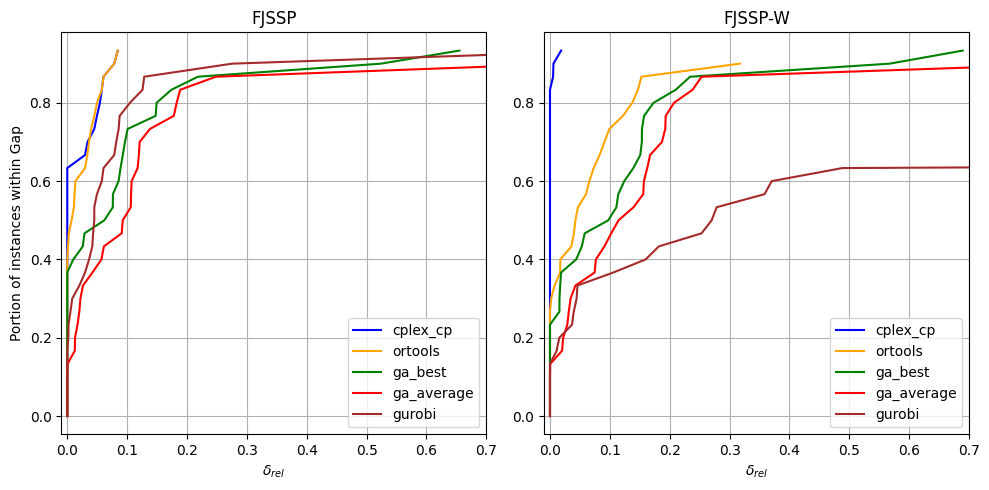

In [196]:
ecdf_inf(solver, instances=filtered_instances, labels=list(solver.keys()), colors=['blue', 'orange', 'green', 'red', 'brown', 'yellow'])
#ecdf_inf(solver['cplex_cp']['no_worker'], instances=filtered_instances)

In [197]:
solver['cplex_cp']['worker']['HurinkSdata1']

{'fitness': 52.0, 'lower_bound': 52.0, 'status': 1.0, 'runtime': 1.898}

In [198]:
solver['ortools']['worker']['HurinkSdata1']

{'fitness': 52.0,
 'lower_bound': 52.0,
 'status': 1.0,
 'runtime': 6.888768600000001}

In [199]:
solver['ga_best']['worker']['HurinkSdata1']

{'fitness': 52.0}

In [200]:
def get_comparison(data, instance, column, max = False):
    best_fjssp = float('inf')
    best_fjssp_w = float('inf')
    for key in data.keys():
        fitness_fjssp = data[key]['no_worker'][instance]['fitness']#optimizer['no_worker']['name'] == instance][column].tolist()[0]
        if fitness_fjssp < best_fjssp:
            best_fjssp = fitness_fjssp
        if instance in data[key]['worker']:
            fitness_fjssp_w = data[key]['worker'][instance]['fitness']#optimizer.loc[optimizer['worker']['name'] == instance][column].tolist()[0]
            if fitness_fjssp_w < best_fjssp_w:
                best_fjssp_w = fitness_fjssp_w
    return best_fjssp, best_fjssp_w

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_cdf_comparison_vector(data : dict, column, max, instances):
    results = []
    for _ in data:
        results.append([[],[]])
    for instance in instances:
        best_fjssp, best_fjssp_w = get_comparison(data, instance, column, max)
        i = 0
        for key in data.keys():
            results[i][0].append(calculate_value(data[key]['no_worker'][instance]['fitness'], best_fjssp))
            if instance in data[key]['worker']:
                results[i][1].append(calculate_value(data[key]['worker'][instance]['fitness'], best_fjssp_w))
            else:
                results[i][1].append(float('inf'))
            i += 1
    for result in results:
        result[0].sort()
        result[1].sort()
    return results

def ecdf_inf(data, column = 'fitness_value', max : bool = False, n_instances : int = 30, labels : list[str] = [], instances : list[str] = [], colors : list[str] = []):
    vectors = get_cdf_comparison_vector(data, column, max, instances)
    plot_vectors = []

    for vector in vectors:
        plot_vectors.append([[[0.0],[0.0]], [[0.0],[0.0]]])
        i = 1
        while i < len(vector[0]):
            if vector[0][i] == float('inf'):
                break
            if vector[0][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0][0].append(vector[0][i-1])
            plot_vectors[-1][0][1].append((i-1)/n_instances)
            i += 1
        i = 1
        while i < len(vector[1]):
            if vector[1][i] == float('inf'):
                break
            if vector[1][i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][1][0].append(vector[1][i-1])
            plot_vectors[-1][1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(vectors)):
        plt.plot(plot_vectors[i][0][0], plot_vectors[i][0][1], label=[labels[i] + ' FJSSP'], c=colors[i], linestyle='dashed', alpha=0.7)
        plt.plot(plot_vectors[i][1][0], plot_vectors[i][1][1], label=[labels[i]+ ' FJSSP-W'], c=colors[i], alpha=0.7)
        shrink = min(len(plot_vectors[i][1][1]),len(plot_vectors[i][0][1]))
        plt.fill_between(plot_vectors[i][1][0], plot_vectors[i][1][1][:shrink], plot_vectors[i][0][1][:shrink], alpha=0.2)
    plt.legend()
    plt.xlim(-0.1, 1.0)
    plt.xlabel('$\delta_{rel}$')
    plt.ylabel('Portion of instances within Gap')
    plt.legend()
    plt.title('FJSSP - FJSSP-W Relative Performance')
    plt.show()


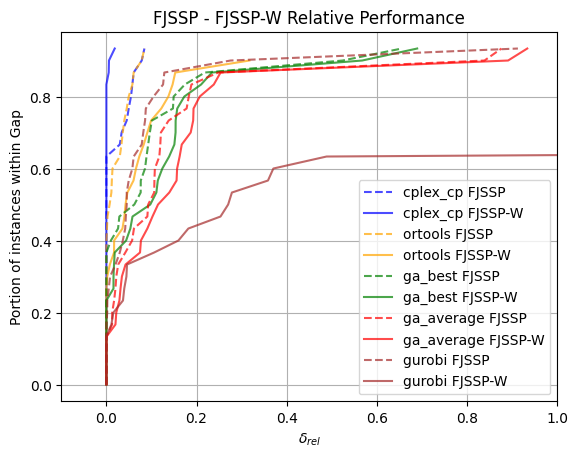

In [201]:
ecdf_inf(solver, instances=filtered_instances, labels=list(solver.keys()), colors=['blue', 'orange', 'green', 'red', 'brown', 'yellow'])